In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/cs/cs171/project

/content/drive/MyDrive/cs/cs171/project


In [ ]:
pwd

'/content/drive/MyDrive/cs/cs171/project'

In [ ]:
!find /content/drive/MyDrive -type d -name "audio"


/content/drive/MyDrive/cs/cs171/project/audio


# Imports ⬇

In [ ]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [ ]:
wav_path = "/content/drive/MyDrive/cs/cs171/project/audio/LOV3_Sik_K.wav"

sr, data = wavfile.read(wav_path)

print("Sample rate:", sr) # 샘플링 레이트는 여기서 초당 몇번 사진을 찍느냐

# 1khz 가 초당 1000번
print("Shape:", data.shape)


Sample rate: 44100
Shape: (10418176, 2)


In [ ]:
print("Dtype:", data.dtype)

Dtype: int16


In [ ]:
print("Min value:", data.min())

Min value: -32768


In [ ]:
print("Max value:", data.max())

Max value: 32767


In [ ]:
print("Mean abs value:", np.mean(np.abs(data)))

Mean abs value: 9444.05832258929


In [ ]:
# Convert stereo to mono
# 스테레오는 소리가 두 줄로 존재하는 것 (L,R 즉 양쪽에서 사운드가 들리는 것임) 근데 우리는 분석을 하기에 양쪽에서 사운드가 불필요함. 그래서 모노로 변환 해서 수치만 따는거 (분석에 필요한 한 줄)

if len(data.shape) == 2:
    mono = data.mean(axis=1) # L과 R 두 값을 평균 내서 하나의 숫자로 만들었다는 뜻
else:
    mono = data

print("Mono shape:", mono.shape)

# wav 파일들은 소리 = 숫자들의 리스트(?) 라고 할 수 있다. 즉, 소리들이 스피커 기준으로 아주 빠르게 앞 뒤로 움직여서 소리를 만듦.
# 양수면 스피커 앞, 음수면 스피커 뒤, 예를들어 0 이라면 무음이라는 뜻



Mono shape: (10418176,)


In [ ]:
print("First 10 samples:", mono[:10]) # sanity check

# 즉 44100개중에서 10개만 정상 체크 한 것임.
# 많은 곡들이 0.1~0.2 초 정도는 조용하게 시작하는 곡들이 많음, 그래서 10개 샘플 값이 다 0

First 10 samples: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
print(mono[10000:10100])

[ -4735.   -4361.5  -4191.   -4341.   -4341.   -3819.   -3669.5  -4789.
  -6701.   -8409.   -9308.5  -9133.   -8001.5  -6578.   -5662.5  -5313.5
  -4932.   -4364.   -4006.5  -4110.   -4686.   -5428.   -5793.   -5739.5
  -5850.5  -6464.   -6992.   -6628.   -5836.5  -5808.5  -6611.5  -7667.
  -8746.   -9409.   -9461.   -9502.5  -9733.   -9744.5  -9590.5  -9728.
 -10197.  -10487.  -10605.5 -11221.5 -11827.5 -11415.5 -10851.  -10959.
 -10715.  -10010.  -10102.  -10959.  -11633.5 -11838.5 -11774.5 -11782.
 -11849.  -11553.5 -11041.5 -10892.  -11193.  -11792.  -12636.5 -13382.5
 -13603.  -13466.5 -13418.5 -13471.5 -13598.5 -13846.  -13792.5 -13477.5
 -13629.  -13765.  -13112.5 -12712.  -13055.  -12817.  -12010.5 -11756.
 -11557.5 -10741.5  -9973.5  -9567.5  -9054.5  -8341.5  -7813.   -7620.
  -7331.5  -6888.5  -7175.   -8261.5  -9006.   -9113.5  -8990.   -8416.5
  -7489.5  -6857.5  -6218.5  -4820. ]


In [ ]:
# 1) 현재 모노 데이터의 최대 절댓값 확인
max_abs = np.max(np.abs(mono))
print("Max abs before normalization:", max_abs)

# 2) -1 ~ 1 사이로 정규화
mono_norm = mono / max_abs

# 곡 마다 천차만별인 모노값 정규화


Max abs before normalization: 32768.0


In [ ]:
# 2) -1 ~ 1 사이로 정규화
mono_norm = mono / max_abs

print("Min after normalization:", mono_norm.min())

Min after normalization: -1.0


In [ ]:
print("Max after normalization:", mono_norm.max())

Max after normalization: 0.999969482421875


In [ ]:
print("First 10 samples after normalization:", mono_norm[:10])

First 10 samples after normalization: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# time axis for the whole audio (in seconds)
duration = len(mono_norm) / sr  # 여기서는 전체 샘플 개수 / 초당 샘플 개수 이렇게 해서 총 노래가 총 몇 초 인지

print("Duration (seconds):", duration)

t = np.arange(len(mono_norm)) / sr


Duration (seconds): 236.23981859410432


In [ ]:
seconds = 10  # show first 10 seconds

# 그냥 sanity check 해본거임. 여기서 10초는 의미가 있는건 아니고 잘 뽑혔나 테스팅 정도?

end_sample = int(seconds * sr)

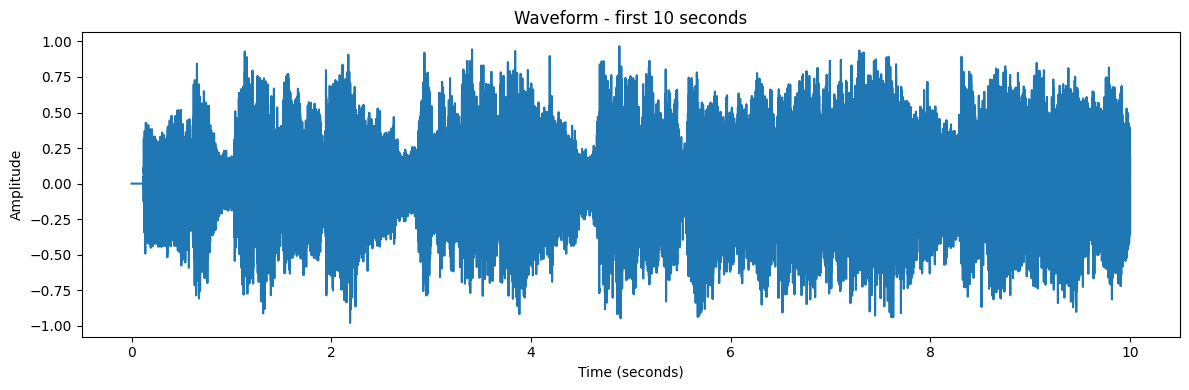

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(t[:end_sample], mono_norm[:end_sample])
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title(f"Waveform - first {seconds} seconds")
plt.tight_layout()
plt.show()

In [ ]:
# 우리 30초만 뽑아볼거니까 여기서 한번 설정을 줘보도록 해볼게.

analysis_seconds = 30

analysis_end_sample = int(analysis_seconds * sr)

# 소리를 엄청 빠르게 잘게 잘라서 숫자 하나씩 저장하는겨. 이것이 점이고 샘플임.
# 초 * 샘플레이트 (sr 요건 위에 나옴) = 그 시간 동안에 들어있는 점의 개수. 쉽게말해 우리가 설정한 시간 동안에 들어있는 데이터의 개수라고 생각하면 됨.

mono_30 = mono_norm[:analysis_end_sample]

# 30초 만큼 떼어서 momo30에 저장

t_30 = np.arange(len(mono_30)) / sr

# 이건 각 샘플이 몇 초 위치인지를 나타내는 시간축 배열을 만듦


In [ ]:
print("30-sec shape:", mono_30.shape)
print("30-sec duration (sec):", len(mono_30) / sr) # 샘플 개수를 다시 초로 변환


30-sec shape: (1323000,)
30-sec duration (sec): 30.0


In [ ]:
# Spectrogram

# 스펙트로그램 할때도 확실히 하려고 다시 찍고
mono_30 = mono_norm[:analysis_end_sample]

# STFT settings (Short Time Fourier Transform의 줄임말임)
# 쉽게 말해서 그냥 소리를 짧게 잘라서 잘린 조각마다 주파수 분석을 하는 방법 (예를들어 음악용 초고속 현미경? 느낌)

n_fft = 2048          # 아까 위에서 짧게 잘라서 분석한다고 했잖아, 그거의 한 덩어리의 크기여. 그니까 2048개의 샘플이 한 개로 취급하는거임 이제부터.
                      # 그리고 2048은 시간정보와 주파수정보의 균형이 최고인 값이라 표준처럼 쓰는 값

hop_length = 512      # 적절한 예 인지는 모르겠는데 파노라마 사진 찍을때 원리가.. 내가 알기로는 아마 천천히 여러사진들이 겹치면서 넓게 나타나는거거든?
                      # 이것도 비슷한 원리야. 그니까 스펙트로그램이 부드럽게 나타나려면 덩어리들이 부분적으로 겹쳐있어야 돼. 그렇게 되어야 끊기지 않고 자연스럽게 연결 된다고 생각하면 돼.
                      # 그럼 512 인 이유는 보통 한 덩어리의 75% 정도를 오버랩 시키는게 표준비율이야 (황금비율 ㅇㅇ)
                      # 정확하게 말해, 1~2048 이 한덩어리라면 다음 덩어리는 512~2559 까지가 그 다음 덩어리. 이런식으로 부드러운 스펙트로그램 만드는 원리임.

window = np.hanning(n_fft)  # STFT 할 때 소리를 2048를 하나의 덩어리로 보잖아? 근데 그냥 뚝 잘라서 FFT 하면, 덩어리의 양 끝이 갑자기 끊기면서 주파수 결과에 가짜 잡음이 생김 / 한덩이 fft, 여러덩이 stft
                            # Hanning window: 자르기 전에 양 끝을 테이프로 살짝 눌러 부드럽게 만든 다음 자르는 느낌



In [ ]:
mono_30

array([ 0.        ,  0.        ,  0.        , ..., -0.52870178,
       -0.4609375 , -0.21403503])

In [ ]:
num_frames = 1 + (len(mono_30) - n_fft) // hop_length

# 전체 길이 = len(mono_30) 샘플. 한 프레임을 만들려면 최소 n_fft(2048) 샘플이 필요.
# 몇 번이나 512씩 옮기면서 프레임을 만들 수 있냐?
# 거기서 첫 프레임(맨앞0에서 시작) 포함하려고 +1
# num_frames = 30초 안에서 우리가 만들 수 있는 STFT 슬라이스 개수.

In [ ]:
num_frames
# 2048 샘플씩 자르되, 매번 512샘플씩 겹치게 이동하면서
# 30초 안에서 만들 수 있는 STFT 프레임 수가 2580개라는 뜻이다.

2580

In [ ]:
stft_matrix = np.zeros((n_fft // 2 + 1, num_frames), dtype=np.complex64)
# np.fft.rfft는 양수 주파수만 돌려줌 -> 주파수 줄 개수 = n_fft // 2 + 1
# 열 개수 = num_frames (시간 축의 프레임 개수) 그래서 전체 모양: (주파수 bin 수, 시간 frame 수)
# 일종의 빈 스펙트로그램 판이라고 보면 됨.

In [ ]:
stft_matrix

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)

In [ ]:
for i in range(num_frames):
    start = i * hop_length
    frame = mono_30[start:start + n_fft]
    frame_windowed = frame * window
    stft_matrix[:, i] = np.fft.rfft(frame_windowed)

# stft_matrix = (주파수 × 시간) 복소수 행렬 완성

In [ ]:
magnitude = np.abs(stft_matrix)

# 복소수에는 진폭 + 위상 정보가 있는데, 스펙트로그램은 보통 얼마나 큰 소리냐(진폭)만 필요.
# np.abs = 복소수의 길이(진폭)만 뽑는 것.
# 그래서 magnitude = 각 주파수 각 시간에서의 소리 세기

In [ ]:
magnitude

array([[1.57287773e-02, 1.96618438e-02, 1.96691956e-02, ...,
        9.26810646e+00, 5.37766981e+00, 1.11871595e+01],
       [1.02942223e-02, 1.00910030e-02, 9.95594729e-03, ...,
        4.63360710e+01, 4.43933449e+01, 5.03706017e+01],
       [2.19070818e-03, 1.65024248e-04, 1.34295944e-04, ...,
        2.70270721e+02, 2.69858856e+02, 2.69038940e+02],
       ...,
       [1.13369264e-04, 5.27996526e-05, 1.29389708e-04, ...,
        2.66933488e-03, 2.34587074e-04, 1.74646935e-04],
       [2.69462471e-05, 6.24536187e-05, 7.61505144e-05, ...,
        2.30721035e-03, 1.73976936e-04, 9.10284725e-05],
       [4.93229709e-05, 1.19295191e-05, 3.42411004e-05, ...,
        1.93399098e-03, 2.31260183e-05, 7.21043907e-05]], dtype=float32)

In [ ]:
spectrogram_db = 20 * np.log10(magnitude + 1e-10)

# 인간 귀는 로그 스케일로 소리를 느껴 그냥 진폭 값보다 dB(decibel) 로 보는 게 더 자연스럽고 보기 좋음.
# 20 * log10(진폭) -> 음향에서 흔히 쓰는 방식.
# + 1e-10 은 log(0) 피하려고 아주 작은 수 더해주는 안전장치.

In [ ]:
spectrogram_db

array([[-36.0661  , -34.127518, -34.124268, ...,  19.33982 ,  14.611883,
         20.974398],
       [-39.74813 , -39.921318, -40.038353, ...,  33.318386,  32.94636 ,
         34.043545],
       [-53.18831 , -75.64904 , -77.43874 , ...,  48.635983,  48.622738,
         48.596306],
       ...,
       [-78.91009 , -85.54737 , -77.762   , ..., -51.47194 , -72.59392 ,
        -75.15678 ],
       [-91.39    , -84.08884 , -82.36655 , ..., -52.73826 , -75.19017 ,
        -80.81645 ],
       [-86.139   , -98.467476, -89.30902 , ..., -54.270912, -92.71794 ,
        -82.84076 ]], dtype=float32)

In [ ]:
times = np.arange(num_frames) * hop_length / sr
freqs = np.fft.rfftfreq(n_fft, d=1/sr)

# 각 프레임은 hop_length 샘플 간격만큼 떨어져 있음. 그래서 * hop_length 하면 “몇 번째 샘플에서 시작하는지”.
# / sr 하면 샘플을 다시 초 단위로 바꿈. (위에서 했었으)
# 결과: times = 각 열(프레임)이 몇 초 지점인지.

# rfft 결과의 각 행이 어떤 주파수(Hz) 인지 계산해줌.
# 결과: freqs = 0 Hz, 21.xx Hz, 43.xx hz 등등 이런 식의 배열.

In [ ]:
times

array([0.00000000e+00, 1.16099773e-02, 2.32199546e-02, ...,
       2.99189116e+01, 2.99305215e+01, 2.99421315e+01])

In [ ]:
freqs

array([0.00000000e+00, 2.15332031e+01, 4.30664062e+01, ...,
       2.20069336e+04, 2.20284668e+04, 2.20500000e+04])

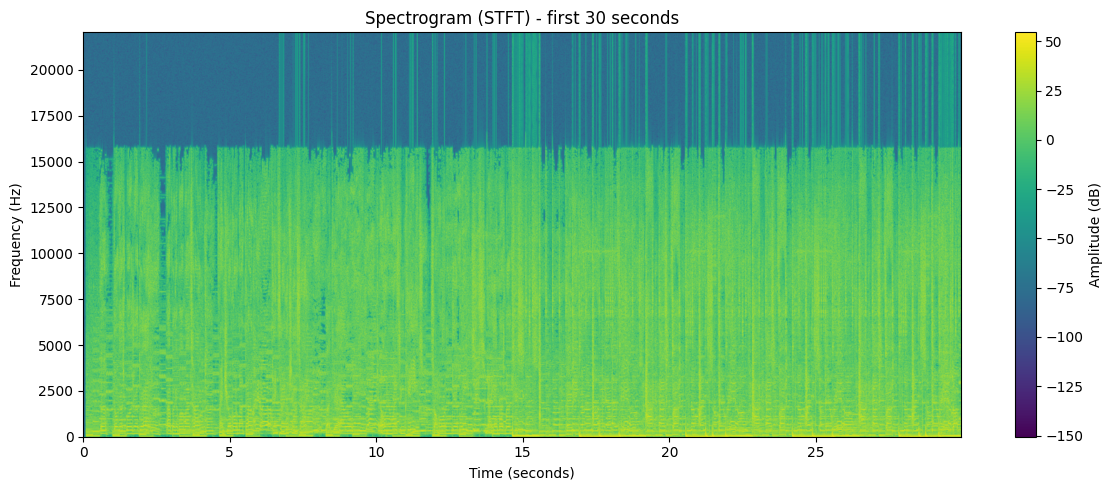

In [ ]:
plt.figure(figsize=(12, 5))
plt.imshow(
    spectrogram_db,
    origin="lower",
    aspect="auto",
    extent=[times[0], times[-1], freqs[0], freqs[-1]]
)
plt.colorbar(label="Amplitude (dB)")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram (STFT) - first 30 seconds")
plt.tight_layout()
plt.show()

# 그래서 이건 곡의 30초만 잘라서, 2048샘플짜리 조각을 512씩 겹치게 이동시키면서 FFT 돌려서 스펙트로그램 만든것임

In [ ]:
# band energy ratio 작업

In [ ]:
low_max = 250      # 베이스(저음) 영역의 위쪽 경계 주파수 (250Hz까지를 저음으로 봄)
mid_max = 4000     # 보컬/메인 악기(중음) 영역의 위쪽 경계 주파수 (4000Hz까지를 중음으로 봄)

In [ ]:
low_idx  = np.where(freqs <= low_max)[0]                       # freqs 배열에서 0 ~ 250Hz 구간에 해당하는 인덱스들 (저음 구간)
mid_idx  = np.where((freqs > low_max) & (freqs <= mid_max))[0] # freqs 배열에서 250 ~ 4000Hz 구간 인덱스들 (중음/보컬 구간)
high_idx = np.where(freqs > mid_max)[0]                        # freqs 배열에서 4000Hz 이상의 인덱스들 (고음/심벌 구간)

In [ ]:
print("Number of bins - low:", len(low_idx),
      "mid:", len(mid_idx),
      "high:", len(high_idx))  # 각 구간(저/중/고음)에 포함된 주파수 칸(bin) 개수 출력

Number of bins - low: 12 mid: 174 high: 839


In [ ]:
power = magnitude ** 2   # 각 주파수-시간 지점의 에너지값을 위해 |스펙트럼|^2 계산 (모양은 magnitude와 동일)

In [ ]:
power

array([[2.47394433e-04, 3.86588101e-04, 3.86877247e-04, ...,
        8.58977966e+01, 2.89193325e+01, 1.25152542e+02],
       [1.05971012e-04, 1.01828344e-04, 9.91208872e-05, ...,
        2.14703149e+03, 1.97076904e+03, 2.53719751e+03],
       [4.79920254e-06, 2.72330034e-08, 1.80354007e-08, ...,
        7.30462656e+04, 7.28238047e+04, 7.23819531e+04],
       ...,
       [1.28525901e-08, 2.78780332e-09, 1.67416960e-08, ...,
        7.12534847e-06, 5.50310943e-08, 3.05015533e-08],
       [7.26100235e-10, 3.90045463e-09, 5.79890092e-09, ...,
        5.32321974e-06, 3.02679730e-08, 8.28618241e-09],
       [2.43275555e-09, 1.42313425e-10, 1.17245291e-09, ...,
        3.74032106e-06, 5.34812694e-10, 5.19904297e-09]], dtype=float32)

In [ ]:
low_energy  = power[low_idx, :].sum()   # 저음 구간 인덱스들에 해당하는 에너지를 전체 시간에 대해 모두 합산
mid_energy  = power[mid_idx, :].sum()
high_energy = power[high_idx, :].sum()

# 중음과 고음파트도 전과 동

In [ ]:
total_energy = low_energy + mid_energy + high_energy  # 세 구간(저,중,고)의 에너지를 모두 더해 전체 에너지 계산

In [ ]:
total_energy

np.float32(202155600.0)

In [ ]:
low_ratio  = low_energy  / total_energy  # 전체 에너지 중에서 저음이 차지하는 비율
mid_ratio  = mid_energy  / total_energy
high_ratio = high_energy / total_energy

# 위에 똑같이 중,고음도 전과 동

In [ ]:
print("Energy ratios (low, mid, high):")
print(low_ratio, mid_ratio, high_ratio)  # (저음 비율, 중음 비율, 고음 비율) 출력

Energy ratios (low, mid, high):
0.58253115 0.35525304 0.062215738


In [ ]:
# 위 곡 (식케이의 Lov3 이라는 곡을 봤을때,)
# 이곡은 저음 비중이 절반이상으로 베이스와 킥 위주의 곡이라고 알 수 있고
# 보컬, 기타, 피아노가 꽤 존재 (중음)
# 고음 (쩅쩅한 사운드)는 비교적 가장 비중이 적다고 할 수 있을듯.

In [ ]:
# mfcc 작업까지 하면 한 곡에 대한 작업은 모두 종료